In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, bernoulli, multivariate_normal

import pymc3 as pm

In [2]:
N    = 2000
b_GP = 1
b_GC = 0
b_PC = 1
b_U  = 2

In [3]:
U = bernoulli.rvs(size=N, p=0.5)*2 -1
G = norm.rvs(size=N)
P = norm.rvs(size=N, loc=b_GP*G + b_U*U)
C = norm.rvs(size=N, loc=b_GC*G + b_PC*P + b_U*U)

In [4]:
with pm.Model() as model:
    alpha   = pm.Normal('alpha', mu=0, sd=1)
    beta_PC = pm.Normal('beta_PC', mu=0, sd=1)
    beta_GC = pm.Normal('beta_GC', mu=0, sd=1)
    sigma   = pm.Exponential('sigma', lam=1)
    mu      = alpha + beta_PC*P + beta_GC*G
    C_edu   = pm.Normal('C_edu', mu=mu, sd=sigma, observed=C)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta_PC, beta_GC, sigma])

In [5]:
mu_posterior = [par_post['alpha'], par_post['beta_PC'], par_post['beta_GC'], par_post['sigma']]
post_sample  = multivariate_normal.rvs(size=10**4, mean=mu_posterior, cov=np.linalg.inv(hessian))
post_sample  = pd.DataFrame(post_sample, columns=['alpha', 'beta_PC', 'beta_GC', 'sigma'])

In [6]:
post_sample.describe()

,alpha,beta_PC,beta_GC,sigma
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.024844,1.804691,-0.771525,1.308530
std,0.029321,0.012918,0.031759,0.020742
min,-0.098846,1.754321,-0.891781,1.227917
25%,0.005109,1.795763,-0.793199,1.294241
50%,0.025004,1.804670,-0.771788,1.308496
75%,0.045038,1.813437,-0.749961,1.322627
max,0.135204,1.852702,-0.647729,1.384551


In [7]:
dat = pd.DataFrame(np.array([C, P, G, U]).T, columns=['C', 'P', 'G', 'U'])

<AxesSubplot:xlabel='G', ylabel='C'>

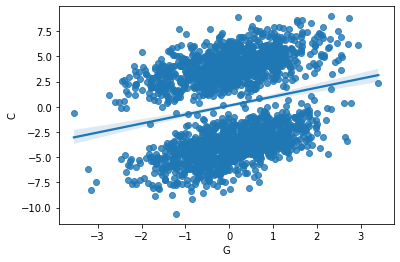

In [8]:
sns.regplot(data=dat, x='G', y='C')
#plt.savefig('regresion_C_given_G.png', transparent=True)

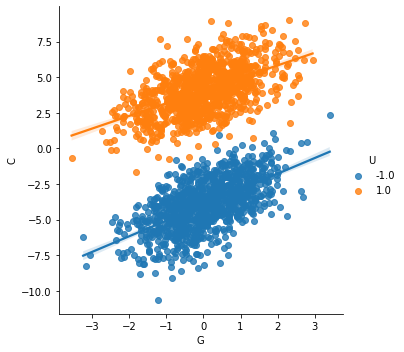

In [9]:
sns.lmplot(data=dat, x='G', y='C', hue='U')
#plt.savefig('regresion_C_given_G_cond_U.png', transparent=True)

In [10]:
dat['selected'] = (P>np.quantile(P, 0.45)) & (P<np.quantile(P, 0.6))

<AxesSubplot:xlabel='G', ylabel='C'>

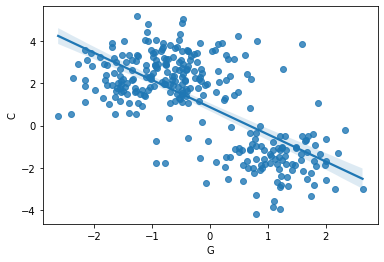

In [11]:
sns.regplot(data=dat[dat['selected']], x='G', y='C')
#plt.savefig('regresion_C_given_G_cond_P.png', transparent=True)

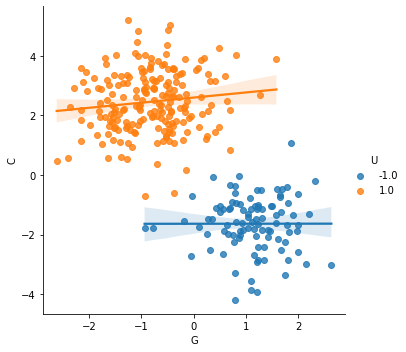

In [12]:
sns.lmplot(data=dat[dat['selected']], x='G', y='C', hue='U')
#plt.savefig('regresion_C_given_G_cond_P_and_U.png', transparent=True)

In [13]:
with pm.Model() as model:
    alpha   = pm.Normal('alpha', mu=0, sd=1)
    beta_PC = pm.Normal('beta_PC', mu=0, sd=1)
    beta_GC = pm.Normal('beta_GC', mu=0, sd=1)
    beta_U  = pm.Normal('beta_U', mu=0, sd=1)
    sigma   = pm.Exponential('sigma', lam=1)
    mu      = alpha + beta_PC*P + beta_GC*G + beta_U*U
    C_edu   = pm.Normal('C_edu', mu=mu, sd=sigma, observed=C)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta_PC, beta_GC, beta_U, sigma])

In [14]:
mu_posterior = [par_post['alpha'], par_post['beta_PC'], par_post['beta_GC'], par_post['beta_U'], par_post['sigma']]
post_sample  = multivariate_normal.rvs(size=10**4, mean=mu_posterior, cov=np.linalg.inv(hessian))
post_sample  = pd.DataFrame(post_sample, columns=['alpha', 'beta_PC', 'beta_GC', 'beta_U', 'sigma'])

In [15]:
post_sample.describe()

,alpha,beta_PC,beta_GC,beta_U,sigma
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.029511,1.035228,-0.016420,1.917721,1.008302
std,0.022442,0.023018,0.032057,0.051970,0.015783
min,-0.049593,0.949944,-0.147398,1.722951,0.947050
25%,0.014670,1.019724,-0.038318,1.882349,0.997688
50%,0.029450,1.035109,-0.016810,1.917796,1.007987
75%,0.044899,1.050815,0.005143,1.953114,1.018942
max,0.110463,1.115647,0.094280,2.132662,1.067836
